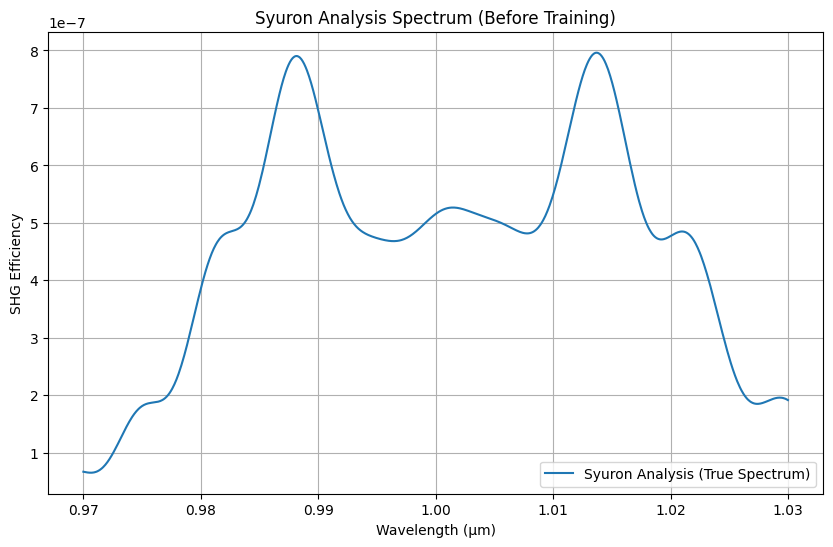

train_data input dim: 100
train_data output dim: 1000
syuron_domain_widths dim: 100
Train batch input shape: (8000, 100)
Train batch output shape: (8000, 1000)
Eval batch input shape: (2000, 100)
Eval batch output shape: (2000, 1000)
Before training, Evaluation Loss: 6603320.0000
Epoch 1, Train Loss: 26413588.0000
Epoch 10, Train Loss: 90064688.0000
Epoch 20, Train Loss: 15003578.0000
Epoch 30, Train Loss: 9833995.0000
Epoch 40, Train Loss: 8012759.5000
Epoch 50, Train Loss: 6380943.5000
Epoch 60, Train Loss: 5751162.0000
Epoch 70, Train Loss: 5538329.0000
Epoch 80, Train Loss: 5462673.0000
Epoch 90, Train Loss: 5436176.0000
Epoch 100, Train Loss: 5426365.5000
Epoch 110, Train Loss: 5423079.0000
Epoch 120, Train Loss: 5421745.5000
Epoch 130, Train Loss: 5421326.0000
Epoch 140, Train Loss: 5421157.5000
Epoch 150, Train Loss: 5421103.5000
Epoch 160, Train Loss: 5421082.5000
Epoch 170, Train Loss: 5421075.0000
Epoch 180, Train Loss: 5421072.0000
Epoch 190, Train Loss: 5421071.0000
Epoch 2

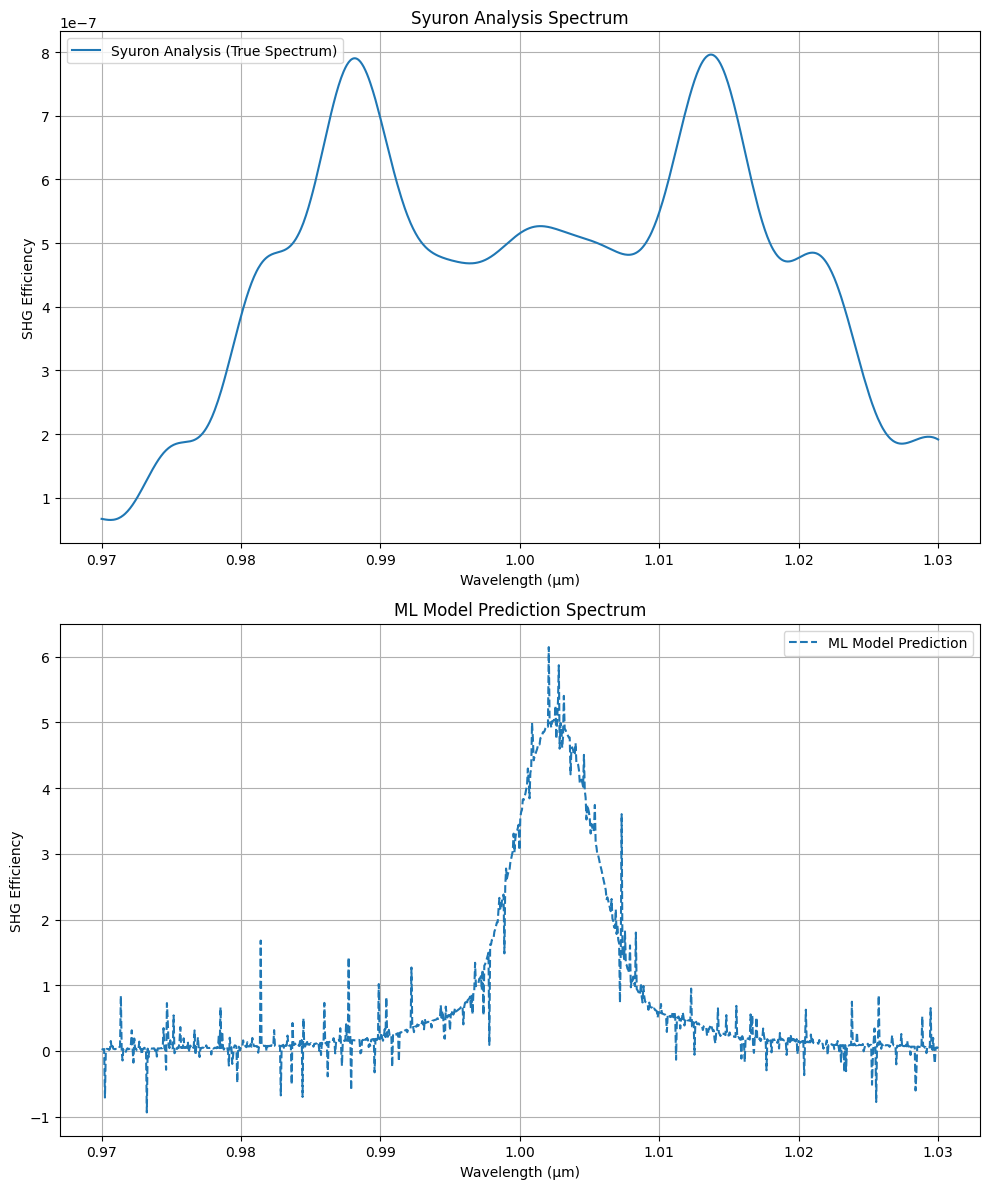

In [ ]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
from flax.training import train_state
import numpy as np
import json
from syuron import shg
from syuron import mgoslt
import matplotlib.pyplot as plt
from typing import List


# --------------------------------------------------
# MLPモデルの定義 (Flaxを用いた全結合ネットワーク)
# --------------------------------------------------
class MLP(nn.Module):
    hidden_sizes: list  # 例: [512, 256]

    @nn.compact
    def __call__(self, x):
        # 隠れ層: 各層でReLU活性化
        for size in self.hidden_sizes:
            x = nn.Dense(size)(x)   # 全結合層
            x = nn.sigmoid(x)       # 活性化関数
        # 出力層: 出力次元は1000
        x = nn.Dense(1000)(x)
        return x


# --------------------------------------------------
# トレーニング状態の作成関数
# --------------------------------------------------
def create_train_state(rng, learning_rate, hidden_sizes):
    model = MLP(hidden_sizes=hidden_sizes)
    # 入力のダミーデータの形状を [1, 100] に変更
    params = model.init(rng, jnp.ones([1, 100]))['params']
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)


# --------------------------------------------------
# 損失関数の定義 (二乗誤差の和)
# --------------------------------------------------
def loss_fn(params, batch, apply_fn):
    # 予測値の取得
    preds = apply_fn({'params': params}, batch['input'])
    # 出力全体の二乗誤差の和を計算
    loss = jnp.sum((preds - batch['output']) ** 2)
    return loss


# --------------------------------------------------
# 1ステップのトレーニング更新（JITコンパイル）
# --------------------------------------------------
@jax.jit
def train_step(state, batch):
    # 損失と勾配を計算
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params, batch, state.apply_fn)
    # 勾配に沿ってパラメータを更新
    state = state.apply_gradients(grads=grads)
    return state, loss


# --------------------------------------------------
# 評価関数の定義
# --------------------------------------------------
def evaluate_loss(state, batch):
    # 評価時は勾配は不要
    return loss_fn(state.params, batch, state.apply_fn)


# --------------------------------------------------
# データセット準備: JSONファイルからデータを読み込み、バッチ作成
# 正規化（Normalization）を適用して出力値をスケールアップする
# --------------------------------------------------
def prepare_batch(dataset, output_scale=1e-6):
    # 入力と出力をそれぞれ配列に変換
    inputs = np.array([sample['input'] for sample in dataset])
    outputs = np.array([sample['output'] for sample in dataset])
    # 出力値を正規化：1e-6で割って、学習中の値のレンジを1程度にする
    outputs_normalized = outputs / output_scale
    return {'input': jnp.array(inputs), 'output': jnp.array(outputs_normalized)}


def load_dataset(json_file_path):
    with open(json_file_path, 'r') as f:
        dataset = json.load(f)
    return dataset


# --------------------------------------------------
# メイン処理: Syuron解析のプロット、データセット拡張、モデル学習と結果比較
# --------------------------------------------------
def main():
    # 乱数の初期化およびハイパーパラメータ設定
    rng = jax.random.PRNGKey(0)
    learning_rate = 1e-3
    hidden_sizes = [512, 256]
    num_epochs = 10000

    # ------------------------------
    # Syuron解析による「真の」SHG効率スペクトルの計算
    # ------------------------------
    domain_stack = mgoslt.use_chirped(655, 7.2, 1.031E-05, 0.0003)
    syuron_domain_widths = [domain.width for domain in domain_stack]
    # 波長の次元: 0.97～1.03 μmの範囲で1000点
    wavelength_dim = jnp.linspace(0.97, 1.03, 1000).tolist()

    params_syuron = shg.Params(
        domain_stack_dim=domain_stack,
        T_dim=70,
        wavelength_dim=wavelength_dim,
        fund_power_dim=1,
        sh_power_dim=0,
        mesh_density=100
    )

    # Chirp解析による効率スペクトルの計算（多次元テンソル）
    eff_tensor_syuron = shg.analyze_ncme(params_syuron, mgoslt.use_material)
    true_spectrum = eff_tensor_syuron[0, 0, :, 0, 0]

    # ------------------------------
    # Syuron解析結果のプロット（学習前の確認用）
    # ------------------------------
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength_dim, true_spectrum,
             label="Syuron Analysis (True Spectrum)")
    plt.title("Syuron Analysis Spectrum (Before Training)")
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("SHG Efficiency")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ------------------------------
    # データセットのロードとSyuron解析結果の追加
    # ------------------------------
    dataset = load_dataset('./dataset.json')

    # ------------------------------
    # データセットの分割とバッチ作成
    # ------------------------------
    # 例として全体の80%をトレーニング、20%を評価に使用
    split_idx = int(0.8 * len(dataset))
    train_dataset = dataset[:split_idx]
    print(f"train_data input dim: {len(train_dataset[0]["input"])}")
    print(f"train_data output dim: {len(train_dataset[0]["output"])}")
    print(f"syuron_domain_widths dim: {len(syuron_domain_widths)}")
    syuron_sample = {
        "input": syuron_domain_widths,
        "output": true_spectrum.tolist()  # ndarrayをリストに変換して保存
    }
    eval_dataset = dataset[split_idx:]
    train_batch = prepare_batch(train_dataset)
    eval_batch = prepare_batch(eval_dataset)

    print("Train batch input shape:", train_batch['input'].shape)
    print("Train batch output shape:", train_batch['output'].shape)
    print("Eval batch input shape:", eval_batch['input'].shape)
    print("Eval batch output shape:", eval_batch['output'].shape)

    # ------------------------------
    # MLモデルのトレーニング前評価
    # ------------------------------
    state = create_train_state(rng, learning_rate, hidden_sizes)
    init_eval_loss = evaluate_loss(state, eval_batch)
    print(f"Before training, Evaluation Loss: {init_eval_loss:.4f}")

    # ------------------------------
    # MLモデルのトレーニング
    # ------------------------------
    for epoch in range(num_epochs):
        state, train_loss = train_step(state, train_batch)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")

    final_eval_loss = evaluate_loss(state, eval_batch)
    print(f"After training, Evaluation Loss: {final_eval_loss:.4f}")

    # ------------------------------
    # 学習済みMLモデルによるSHG効率スペクトルの予測
    # ------------------------------
    input_ml = jnp.array(syuron_domain_widths).reshape(1, -1)  # 入力形状
    predicted_spectrum = state.apply_fn({'params': state.params}, input_ml)
    predicted_spectrum = predicted_spectrum[0]  # バッチ次元を除去

    # ------------------------------
    # 学習結果とSyuron解析結果の比較プロット
    # ------------------------------
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # サブプロット1: Syuron解析結果のプロット
    ax1.plot(wavelength_dim, true_spectrum,
             label="Syuron Analysis (True Spectrum)")
    ax1.set_title("Syuron Analysis Spectrum")
    ax1.set_xlabel("Wavelength (μm)")
    ax1.set_ylabel("SHG Efficiency")
    ax1.legend()
    ax1.grid(True)

    # サブプロット2: MLモデル予測結果のプロット
    ax2.plot(wavelength_dim, predicted_spectrum,
             label="ML Model Prediction", linestyle='--')
    ax2.set_title("ML Model Prediction Spectrum")
    ax2.set_xlabel("Wavelength (μm)")
    ax2.set_ylabel("SHG Efficiency")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()